## Data Cleaning

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score


# import the dataset
spotify_tracks = pd.read_csv('archive/tracks.csv')

# drop duplicates with the same name and artist
spotify_tracks = spotify_tracks.drop_duplicates(
  subset = ['name', 'artists'],
  keep = 'last').reset_index(drop = True)

# convert release_time to appropriate time date format
spotify_tracks['release_date']= pd.to_datetime(spotify_tracks['release_date'])

# remove songs older than 1990
spotify_tracks = spotify_tracks[spotify_tracks['release_date'].dt.year >= 1990]

# change duration from ms to minutes
spotify_tracks['duration_ms'] = spotify_tracks['duration_ms']/60000

# rearrange columns
spotify_tracks = spotify_tracks[['id',
        'name',
        'artists',
 'id_artists',
 'release_date',
 'duration_ms',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'popularity',
]]

# reset index
spotify_tracks = spotify_tracks.reset_index(drop=True)

# identify IQR for duration and remove outliers
Q1 = np.percentile(spotify_tracks['duration_ms'], 25,
                   method = 'midpoint')
Q3 = np.percentile(spotify_tracks['duration_ms'], 75,
                   method = 'midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
upper_array=np.where(spotify_tracks['duration_ms']>=upper)
lower_array=np.where(spotify_tracks['duration_ms']<=lower)

spotify_tracks.drop(upper_array[0],inplace=True)
spotify_tracks.drop(lower_array[0],inplace=True)

# remove songs with time signature = 0, 1
spotify_tracks = spotify_tracks[(spotify_tracks['time_signature'] != 0) & 
                                (spotify_tracks['time_signature'] !=1)]

# remove songs with high speechiness like talk shows, audio books, poetry
spotify_tracks = spotify_tracks[spotify_tracks['speechiness']<0.8]

# remove songs with live audiences
spotify_tracks = spotify_tracks[spotify_tracks['liveness']<0.9]

# drop the artist_id, since we have the artist name
spotify_tracks.drop(columns = ['id', 'id_artists'], inplace=True)

# drop all null values
spotify_tracks = spotify_tracks.dropna()

# separate releasedate to month and year and drop releasedate
spotify_tracks['month'] = pd.DatetimeIndex(spotify_tracks['release_date']).month
spotify_tracks['year'] = pd.DatetimeIndex(spotify_tracks['release_date']).year
spotify_tracks.drop(columns = ['release_date'], axis = 1, inplace=True)

## Feature Engineering

<AxesSubplot:>

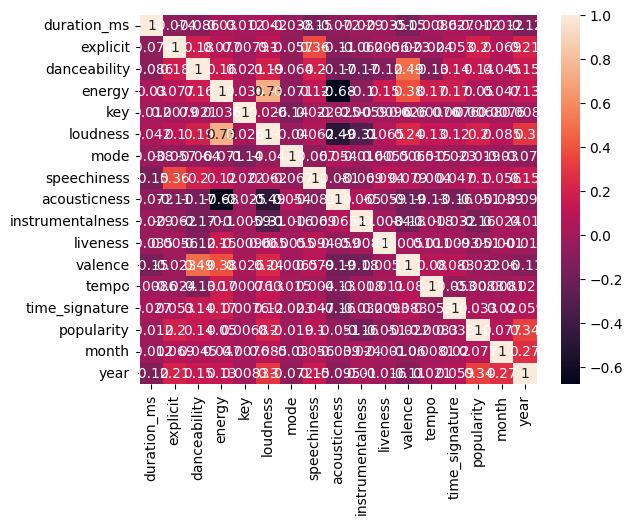

In [2]:
# calculcate the correlation matrix
corr = spotify_tracks.corr()

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

In [3]:
# it seems like energy/loudness, as well as loudness/acousticness are correlated, and energy/acousticness; decide to remove acousticness and loudness
spotify_tracks.drop(columns = ['loudness', 'acousticness'], inplace=True)

# also drop the artist name for now. the alternative is to one-hot encode it, but it takes too much memory (see below)
spotify_tracks.drop(columns = ['artists'], inplace=True)

# artists_ohe = pd.get_dummies(spotify_tracks['artists'])
# spotify_tracks = spotify_tracks.drop('artists', axis = 1)
# spotify_tracks = spotify_tracks.join(artists_ohe)

# ensure that song name is a string
spotify_tracks['name'] = spotify_tracks['name'].astype(str)

# remove all non alphanumeric characters in song name
spotify_tracks['name'] = spotify_tracks['name'].replace(r'[^A-Za-z0-9\s]+', '', regex=True)

# remove extra spaces in song name
spotify_tracks['name'] = spotify_tracks['name'].replace(r'\s\s+', ' ', regex=True)

# strip all stop words (e.g. the, and, or)
spotify_tracks['name'] = spotify_tracks['name'].replace(r'(\s*\b(?:a|an|and|are|as|at|be|but|by|for|if|in|into|is|it|no|not|of|on|or|such|that|the|their|then|there|these|they|this|to|was|will|with|my|oh|i|were|werent|was|wasnt|do|does))\b', '', regex=True)

# remove all special characters, including punctuation
spotify_tracks['name'] = spotify_tracks['name'].replace(r'[^\w\s]|_', '', regex=True)

# make all characters in song name lowercase
spotify_tracks['name'] = spotify_tracks.name.apply(lambda x: x.lower())

# perform count vectorizer (goal is to see if song name has impact on popularity)
count_vect = CountVectorizer(binary=False, min_df=100)
name_vectorized = count_vect.fit_transform(spotify_tracks['name'])

# drop the song name column and add the new vectorized song name
spotify_tracks = spotify_tracks.drop('name', axis = 1)
count_vect_df = pd.DataFrame(name_vectorized.todense(), columns = count_vect.get_feature_names_out())
spotify_tracks = pd.concat([spotify_tracks.reset_index().drop('index', axis = 1), count_vect_df.reset_index().drop('index', axis = 1)], axis = 1)

## Baseline Model - Linear Regression

In [4]:
# split the data into training and test sets
df_train, df_test = train_test_split(spotify_tracks, test_size = 0.2)

# create the features and target dataframes
df_train_x = df_train.drop('popularity', axis = 1).to_numpy()
df_train_y = df_train['popularity'].values

df_test_x = df_test.drop('popularity', axis = 1).to_numpy()
df_test_y = df_test['popularity'].values

# fit the linear regression model
LinReg = LinearRegression()
LinReg.fit(df_train_x, df_train_y)

# get score on test-set
test_score = LinReg.score(df_test_x, df_test_y)

# print the score
print(f"R2 score for test set is {test_score}")

R2 score for test set is 0.27939120284156715


## Baseline Model - Logistic Regression

In [5]:
# convert popularity into different 4 classes
spotify_tracks['popularity_bucket'] = spotify_tracks['popularity'] // 25

# replace numerical classes with string classes
class_dict = {0: 'Not Popular', 1: 'Somewhat Popular', 2: 'Popular', 3: 'Very Popular'}
spotify_tracks['popularity_bucket'] = spotify_tracks['popularity_bucket'].replace(class_dict)
spotify_tracks.drop(columns = ['popularity'], inplace=True)

# split the data into training and test sets
df_train, df_test = train_test_split(spotify_tracks, test_size = 0.2)

# create the features and target dataframes
df_train_x = df_train.drop('popularity_bucket', axis = 1).to_numpy()
df_train_y = df_train['popularity_bucket'].values

df_test_x = df_test.drop('popularity_bucket', axis = 1).to_numpy()
df_test_y = df_test['popularity_bucket'].values

# fit the logistic regression model with no regularization terms
LogReg = LogisticRegression(multi_class='ovr', penalty='none', max_iter = 10000)
LogReg.fit(df_train_x, df_train_y)

# calculate F1 score
f1_train = f1_score(df_train_y, LogReg.predict(df_train_x), average = 'micro')
f1_test = f1_score(df_test_y, LogReg.predict(df_test_x), average = 'micro')

# print F1 values out
print(f"Training set with no regularization terms F1-Score is {f1_train}")
print(f"Test set with no regularization terms F1-Score is {f1_test}")

Training set with no regularization terms F1-Score is 0.5635354176959089
Test set with no regularization terms F1-Score is 0.5637256747092257


In [6]:
print(spotify_tracks)

        duration_ms  explicit  danceability  energy  key  mode  speechiness  \
0          2.669783         0         0.484   0.265    0     1       0.0322   
1          2.659333         0         0.671   0.867    2     1       0.0571   
2          2.366450         0         0.405   0.365    6     0       0.0289   
3          3.946667         0         0.269   0.129    7     0       0.0576   
4          1.920667         0         0.409   0.639    6     1       0.0302   
...             ...       ...           ...     ...  ...   ...          ...   
265664     4.304450         0         0.560   0.518    0     0       0.0292   
265665     2.554883         0         0.765   0.663    0     1       0.0652   
265666     3.126683         0         0.535   0.314    7     0       0.0408   
265667     2.366717         0         0.696   0.615   10     1       0.0345   
265668     3.572667         0         0.686   0.723    6     1       0.0363   

        instrumentalness  liveness  valence  ...  y